# Finding 0s and 1s in a Forest of Combined Shapes

Candidate: 10111

In [ ]:
import numpy as np
import scipy as sp
from scipy import linalg
from matplotlib import pyplot as plt, animation 
np.random.seed(123)

#Imported packages for the animations
from IPython.display import HTML, Image

from pathlib import Path
directories = ["Animations"]
for directory in directories:
    Path(directory).mkdir(parents=True, exist_ok=True)

# Introduction
As a student at NTNU, I am constantly bombarded by people who are trying to catch my attention. This is especially bad at Sentralbygget, where it is practically impossible to walk from A to B without being approached by someone who wants to recruit you to "Klovneløpet" or to become a Tekna-member. Standing in the centre of all this noise might feel a little chaotic, and one might find it hard to separate all the signals from the different stands. Wouldn't it then be nice to have a way to separate these signals from each other, and actually be able to hear whatever these enthusiastic stand people are trying to tell you?

In this project I will attempt to do exactly this, although in a slightly simplified manner, with only two sources. The end-target will here be to be able to separate, to some extent, images, from the MNIST data set, that are superpositions of images of 0s and 1s, into separate images of 0s and 1s. Below is a GIF that illustrates examples of combined images to the left, and separated images in the centre and to the right, made with the "minimal norm" method.

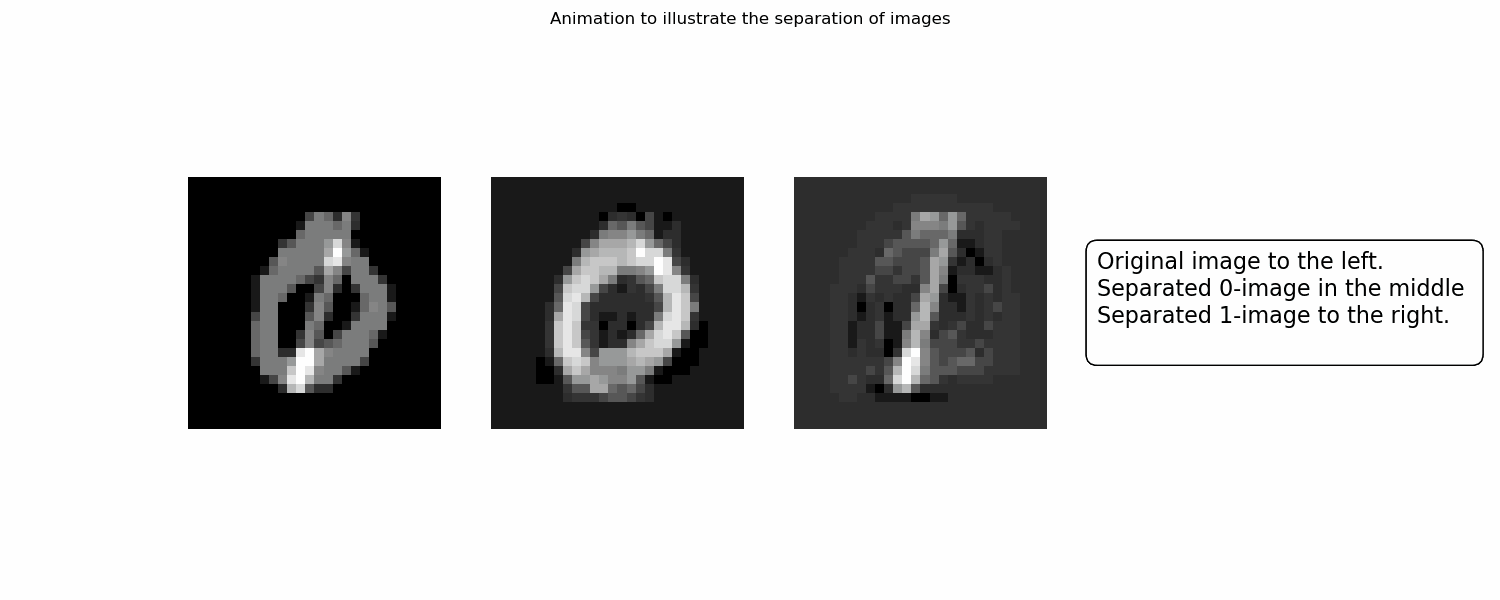

In [ ]:

with open('Animations/least_norm.gif','rb') as file:
    display(Image(file.read()))
plt.close()


However, in order to get to these separated images, there is a bit of theoretical groundwork that has to be done first, especially concerning the "minimal norm" and "Tikhonov regularization" methods. Therefore, this project will continue with some theoretical explorations and proofs, first for the "minimal norm" method, and then for the "Tikhonov regularization" method. Then, having checked that I am able to implement these methods in Python to solve some easier problems, I will turn my focus toward the MNIST dataset and the "single channel source separation" problem. 

# Task 1

## 1.a)

### (1)

For the following system there exists no vector $\textbf{x}$ such that $A\textbf{x}=\textbf{y}$.

$$A = 
\begin{bmatrix}
1 & 1 & 1 \\
2 & 2 & 2
\end{bmatrix} \quad
\textbf{y}=
\begin{bmatrix}
1 \\ 3
\end{bmatrix}
$$

This can be seen by row-reducing as follows:

\begin{array}{@{}ccc|c@{}}
     1 &  1 & 1 & 1 \\
    2 &  2 & 2 & 3 
\end{array}

\begin{array}{@{}ccc|c@{}}
     1 &  1 & 1 & 1 \\
     0 &  0 & 0 & 1 
\end{array}

Where there exists no $x, y, z$ such that $0*x+0*y+0*z=1$, so there exists no $\textbf{x}=[x, y, z]^T$, such that $A\textbf{x}=\textbf{y}$. This could also be seen by the fact that row 1 and 2 in A are not linearly independent, row 2 is in fact row 1 scaled by the factor 2, while $y_2\neq 2*y_1$.

### (2)

For the following system there exists infinitely many vectors $\textbf{x}$ such that $A\textbf{x}=\textbf{y}$. 
$$A = 
\begin{bmatrix}
1 & 1 & 1 \\
2 & 2 & 2
\end{bmatrix} \quad
\textbf{y}=
\begin{bmatrix}
1 \\ 2
\end{bmatrix}
$$

By row-reduction we get that the second row yields the equation $0*x+0*y+0*z$, which by fixing $y=s, z=t$, we see that all $\textbf{x}$ can be written on the form $\textbf{x}=[1-s-t, s, t]^T$, which for $s, t \in \mathbb{R}$ gives infinitely many solutions for $\textbf{x}$.


## 1.b)

For a matrix $A$ to be symmetric, the following equality must hold, $A=A^T$. By using the identity $(AB)^T=B^TA^T$, we here see that 

$$
(A^TA)^T=A^T(A^T)^T=A^TA
$$
and
$$
(AA^T)^T=(A^T)^TA^T=AA^T
$$
Which means that both matrices are symmetric $\square$  
In order for $A^TA$ to be positive semi-definite, we must have that

$$
\textbf{x}(A^TA)\textbf{x} \geq 0  \quad ∀ \textbf{x} \in \mathbb{R}^n
$$
By writing this out and using the fact that $\textbf{x}^T\textbf{x}=||\textbf{x}||^2$, we see that we can write
$$
(A\textbf{x})^T(A\textbf{x})\geq0
$$
$$
||A\textbf{x}||^2\geq 0
$$
Which holds for all $\textbf{x}$, as the norm is never negative. Thus, the matrix is positive semi-finite.

Now I can consider the invertibility of these matrices, for example as follows for $AA^T$. Since I have already shown that this matrix is symmetric and semi-positive definite, I can now determine if it is symmetric positive definite, or SPD, as well, because it would then also be invertible. For a SPD matrix $C$ we have that

$$
\textbf{x}^TC\textbf{x} > 0 \quad ∀ \textbf{x} \neq \textbf{0}
$$
In this case we can write as follows

$$
\textbf{x}^TAA^T\textbf{x}=\|A^T\textbf{x}\|^2
$$

Now, this term is positive, as it is a squared norm, as long as $A^T\textbf{x} \neq \textbf{x}$. However, since $A$ is of full rank, and a wide matrix, the thin matrix $A^T$ has $m$ linearly independent columns, and the only solution to the equation $A^T\textbf{x}=\textbf{0}$, is exactly $\textbf{x}=\textbf{0}$. This means that that $AA^T$ is SPD, and thus invertible. $\square$ That this matrix is in fact invertible will be useful in the next problem, where I will derive an expression for $\textbf{x}_{min}$

For the other matrix, $A^TA$, we can go along in the same manner

$$
\textbf{x}^TA^TA\textbf{x}=\|A\textbf{x}\|^2
$$
Now however, since $A$ has full rank, equal to $m$, and $m<n$. We know that A cannot have $n$ linearly independent columns, and thus the set of equations $A\textbf{x}=\textbf{0}$ has infintely many solutions, meaning that $A^TA$ is not SPD. Of course a matrix can be invertible, and not SPD, but I am unable to say something more regarding this matrix' invertibility as of now. 

## 1.c)
Here we have the Lagrange-function

$$
L(\textbf{x}, \lambda)=\textbf{x}^T\textbf{x}+\lambda^T(A\textbf{x}-\textbf{y})
$$

We now want to consider the gradients of $L$ with respect to $\textbf{x}$ and $\lambda$.

$$
\nabla _{\textbf{x}}L = \nabla _{\textbf{x}}(\textbf{x}^T\textbf{x})+\nabla _{\textbf{x}}(\lambda^TA\textbf{x})-\nabla _{\textbf{x}}(\lambda^T\textbf{y}) = \nabla _{\textbf{x}}(||I\textbf{x}||^2)+\nabla _{\textbf{x}}(A^T\lambda)^T\textbf{x}+0
$$

From exercise 2 I know that 
$$
\nabla _{\textbf{x}}(||I\textbf{x}||^2)=2\textbf{x}
$$
Since
$$
\nabla _{\textbf{x}}(\textbf{x}^TC\textbf{x})=(C^T+C)\textbf{x}
$$
While, in order to find the second gradient, I can first consider the gradient of a vector left-multiplied by a transposed vector. Then we have that
$$
\textbf{d}^T\textbf{x}=d_1x_1+...+d_nx_n
$$
Which implies that 
$$
\nabla _{\textbf{x}}(\textbf{d}^T\textbf{x})=\textbf{d}
$$
So that we must have 
$$
\nabla _{\textbf{x}} L = 2\textbf{x}+A^T\lambda
$$
The reason we calculate the gradients is because we want to set them equal to zero, so that we here have
$$
\nabla _{\textbf{x}} L= 0
$$
This gives that 

$$
\textbf{x}=-\frac{1}{2}A^T\lambda
$$
For the gradient with respect to $\lambda$, we can now write
$$
\nabla_{\lambda}L = \nabla_{\lambda}(\textbf{x}^T\textbf{x})+ \nabla_{\lambda}(\lambda^TA\textbf{x}) - \nabla_{\lambda}(\lambda^T\textbf{y})  \\
=A\textbf{x}-\textbf{y}
$$
Together this yields the equations
$$
\textbf{x}=-\frac{1}{2}A^T\lambda  \\
A\textbf{x}=\textbf{y}
$$
Which means that 
$$
-\frac{1}{2}AA^T\lambda=\textbf{y}  \\
\lambda = -2(AA^T)^{-1}\textbf{y}
$$
Inserted in the expression for $\textbf{x}$ this gives our final expression,

$$
\textbf{x}_{min} = A^T(AA^T)^{-1}\textbf{y} \quad \square
$$

## 1.d)
Here I want to use that $A^T=QR$, which also means that $A=(QR)^T=R^TQ^T$ for an orthogonal matrix $Q$ and a upper-triangular matrix $R$. Using this we can write

$$
x_{min}=A^T(AA^T)^{-1}\textbf{y}=QR(AQR)^{-1}\textbf{y}=QR(R^TQ^TQR)^{-1}\textbf{y}
$$
Now, since we know that $Q$ is an orthogonal matrix, that is, $Q^TQ=I$, we can write
$$
x_{min}=QR(R^TR)^{-1}\textbf{y}
$$
Now, using the following relation for the inverse of a product, $(AB)^{-1}=B^{-1}A^{-1}$, we get that 
$$
x_{min}=QRR^{-1}(R^T)^{-1}\textbf{y} = QR^{-T}\textbf{y} \quad \square
$$

Below I implement a modified version of the Gram Schmidt-algorithm, which is later used in order to calculate the QR decomposition.  

In [ ]:
def modifiedGramSchmidt(A):
    """
    Function that calculates an orthonormal basis for the column space of the 
    matrix A by using the modified Gram-Schmidt-algorithm. Which is often more
    numerically stable, as we can reduce the error in each projection

    Input: 
        A - Transposed matrix, such that each element is a column vector.

    Output:
        V - Orthonormal basis for the column space of A
    """
    V= np.copy(A)
    n = len(V)
    for k in range(n):
        for j in range(k+1, n):
            V[j] = V[j] - np.dot(V[k], V[j])/np.dot(V[k], V[k])*V[k] #Projection
        V[k]= V[k]/np.linalg.norm(V[k], 2) #Normalization
    return V

Now, one might ask oneself why I would need an orthonormal basis. The reason for this is that it is essential in the truncated QR decomposition that I wish to implement in order to solve our problems. I use the truncated QR decomposition because in the normal QR decomposition many columns normally hold redundant information, and thus the truncated version is the sustainable choice when it comes to storage. From the expression below, we see that if we for the column-vectors $\left\{ \textbf{a}_i \right \}_{i=1}^n$ can find an orthonormal basis $\left\{ \textbf{q}_i \right \}_{i=1}^n$, we have the following decomposition for $A$
$$
A = \tilde{Q}\tilde{R} = 
\begin{bmatrix}
\textbf{q}_1 && ... && \textbf{q}_n
\end{bmatrix}
\begin{bmatrix}
\langle \textbf{a}_1, \textbf{q}_1 \rangle && ... && \langle \textbf{a}_n, \textbf{q}_1 \rangle \\ 
0 && \ddots && \vdots \\
0 && 0 && \langle \textbf{a}_n, \textbf{q}_n \rangle
\end{bmatrix}
$$
Below I implement a function for calculating this decomposition

In [ ]:
def QRDecomposition(A):
    """
    Function that calculates the truncated QR for a matrix A, either by using 
    MGS or CGS
    Input:
        A - mxn-matrix
    Outut:
        Q - mxn-matrix
        R - Upper triangular nxn-matrix 
    """
    m, n = np.shape(A)
    if m < n:
        return "Incorrect shape!"
    #Calculating the orthonormal basis
    orthogonalBasis = modifiedGramSchmidt(np.transpose(A))
    #Making Q, and then filling up R
    Q = np.transpose(orthogonalBasis)
    R = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            R[i, j] = np.dot(A[:,j], Q[:, i])
    return Q, R

## 1.e)
To avoid the costly calculation of the inverse of the matrix $R^T$, we can instead rewrite the expression in the following way, by first left-multiplying by $Q^T$:

$$
\textbf{x}_{min}=QR^{-T}\textbf{y} \\
Q^T\textbf{x}_{min}=Q^TQR^{-T}\textbf{y}
$$
And since $Q$ is orthogonal, we get
$$
Q^T\textbf{x}_{min}=R^{-T}\textbf{y}
$$
So if we now left-multiply by $R^T$, we get
$$
R^TQ^T\textbf{x}_{min}=\textbf{y}
$$
Since we know that $R^{-T}=(R^T)^{-1}$.
This is an equation we have solved before, in exercise 1, since $R^T$ is a lower triangular matrix, and we can use forward-substitution to solve 
$$
R^T\textbf{z}=\textbf{y}
$$
Having solved for $\textbf{z}$ we can then utilize the fact that $Q^T=Q^{-1}$, such that we lastly can solve for our $\textbf{x}_{min}$ as follows:
$$
\textbf{x}_{min}=Q\textbf{z}
$$
This is done in the following chunk of code

In [ ]:
def forward_substitution(A, b):
    """
    Function to solve the system of equations represented by Ax=b, where A
    is a lower triangular matrix
    Input:
        A - square, lower triangular matrix
        b - n-dimensional vector, right hand side of the equation
    Output:
        x - The solution of the system (n-dimensional vector)
    """
    n = A.shape[0]
    x = np.zeros(n) #initializes list of solutions
    x[0] = b[0]/A[0,0] #first solution
    for i in range(1,n):
        x[i] = (b[i]-np.dot(A[i,:i],x[:i]))/A[i,i] #computes the rest of the solutions
    return x

def xmin(Q, R, y):
    """
    Function that used the QR decomposition to solve our "least norm"-problem
    according to the equations that have previously been derived in the project
    Input:
        Q - (mxn)-dimensional matrix. Contains the vectors from the orthonormal basis
        R - (nxn)-dimensional upper triangular matrix, containing the inner products
        between the orthonormal vectors and the columns of the original matrix
        y - m-dimensional vector, right-hand-side of the equation
    Output:
        xmin - The vector that minimizes the problem ||Ax-y||, m-dimensional
    """
    z = forward_substitution(np.transpose(R), y)
    return Q @ z
    

Here I initally wanted to test my method on the systems that I presented earlier, but I eventually realized that this would not bear any fruits, since the columns are linearly dependent, meaning that the Gram-Schmidt algorithm would fail. Or rather actually I would have failed, as I had tried to use an algorithm with invalid input.

Therefore I have instead considered an example from the project text. Here we considered a minimal norm-problem, concerning the closest point, in Euclidean norm, to zero on the line $2x_2=x_1+1$. 
Here we're interested in a $\textbf{x}_{min}$ such that
$$
\textbf{x}_{min}=\arg \min_{\textbf{x}\in \mathbb{R}^n} \textbf{x}^T\textbf{x} \quad A\textbf{x}=\textbf{y}
$$
$$
A=\begin{bmatrix} 2 && 1 \end{bmatrix} \quad \textbf{y}=[1]
$$


In [ ]:
A1 = np.array([[2, 1]], dtype=np.float64)
y1 = np.array([1], dtype=np.float64)
Q, R = QRDecomposition(A1.T)
xmin1 = xmin(Q, R, y1)
print(xmin1)

[0.4 0.2]


These results are the same as the geometrical results I have also found and presented below from Geogebra. 

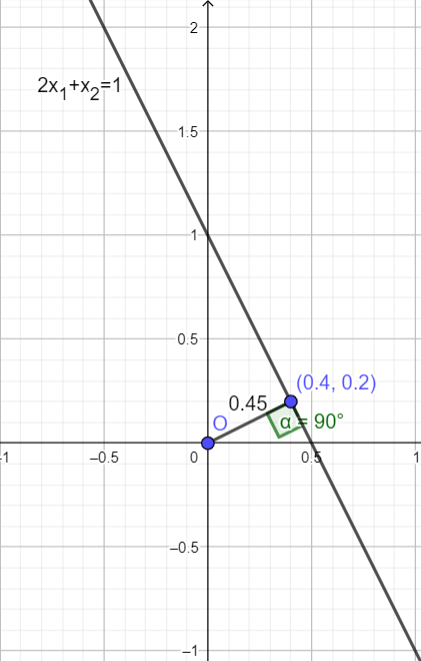

From the results above, one can already see one of the benefits of this method compared to others. Having calculated the QR decomposition of $A_1$, one only needs to use the xmin()-function, which uses the decomposition to solve a system of equations, and perform a matrix multiplication. Thus, I could now find solve this problem for all lines on the form $2x_1+x_2=\alpha$, where $\alpha$ is some constant, since the only thing that would then change is the $\textbf{y}=\alpha$. This is not necessarily very useful, as you could after finding this point that solves the problem above, just calculate the equation of the straight line between the origin and this point. Then all of the following points for different $\alpha$ would just be the intercept between this line and the line for the given $\alpha$.
However, as the system size increases, having precalculated the QR decomposition might be an advantage. Nevertheless, this still remains to be examined, and to say something about how fast this method really is, I will now have to test it more thoroughly. 

## 1.f)
Now I want to test the QR method numerically for a larger system, and compare it to the, probably better, Numpy methods. Here I have made use of code provided in a supplementary notebook to the project, mainly for generating the full rank matrix $A$, with correlated columns, as done below. I have also used the code for generating $X$ and $Y$, which are two matrices where $X$ contains $100$ vectors of size $m$, where each vector is componentwise independent and identically standard normal distributed. The $Y$ matrix then contains the solutions of solving $\textbf{y}=A\textbf{x}$, so that I can again use the QR method which I have implemented earlier, and a Numpy method, for finding $\textbf{x}_{min}$.

In [ ]:
def generate_A(m,n):
    """
    Generates m times n with correlated columns.
    Input:
        m: int, first dimension of A
        n: int, second dimension of A
    output:
        A: (m,n) array
    """

    cov_eigvecs = np.random.uniform(-1.0,1.0,(n,n))
    cov = cov_eigvecs.T @ cov_eigvecs
    v = np.sqrt(np.diag(cov))
    outer_v = np.outer(v, v)
    corr = cov / outer_v
    corr[cov == 0] = 0
    chol = sp.linalg.cholesky(corr, lower=True) 
    A = np.random.normal(0, 1.0,(m,n))
    A = np.dot(A,chol.T)
    return A

In [ ]:
#Provided code for making the matrices X and Y
m = 2048
n = 8096
A = generate_A(m,n)

N = 100 # Number of test data we want to generate

# Generate solutions X columnwise, X[:,i] to access i-th vector
X = np.random.normal(0.0,1.0,(A.shape[1], N))

# Generate left hand sides Y columnwise Y[:,i] to access lhs
Y = np.dot(A,X)

I start with finding $\textbf{x}_{min}$ with the QR method. Here I expect that this algorithm is rather slow, and that using Numpy might lead to a significant improvement in runtime, as these are "well written programs that clever people have spent tens of years optimizing". In the first code chunk below I precalculate things that don't need to be timed, and in the chunk below that one, I time the QR method. I have tried to remain consistent with my choice of $r$, which controls the number of runs of the cell. However, one could of course also include a fixed value for $n$, which decides the number of loops in each loop. Then the fastest of these runtimes would then be chosen as the runtime in the run. Ideally this number could of course have been higher, but my computational resources have not been enough to sustain this, and I believe that a mean of three runs should be enough to consider the runtime. 

In [ ]:
m = np.shape(Y)[1]

In [ ]:
%%timeit -r 3
global Q, R
Q, R = QRDecomposition(A.T)

53 s ± 64.5 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [ ]:
%%timeit -r 3
global AAT
AAT = A @ np.transpose(A)

290 ms ± 26.4 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


Here we see that computing the QR decomposition is rather costly, compared to the the precalculations needed for the Numpy method. Below I time the actual solving-part of the methods.

In [ ]:
%%timeit -r 3
for i in range(m):
    y = Y[:, i]
    x_min = xmin(Q, R, y)


7.26 s ± 145 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [ ]:
%%timeit -r 3
for i in range(m):
    y = Y[:, i]
    z = np.linalg.solve(AAT, y)
    x_min = np.transpose(A)@z


11.1 s ± 53.5 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In this situation the Numpy method is significantly faster overall compared to the QR decomposition method. However, had we wanted to solve for even more different right hand sides, the QR method would probably come out victorious of the duel, since the actual solving-part of the numerical work is done faster in the QR method than in the Numpy method. 

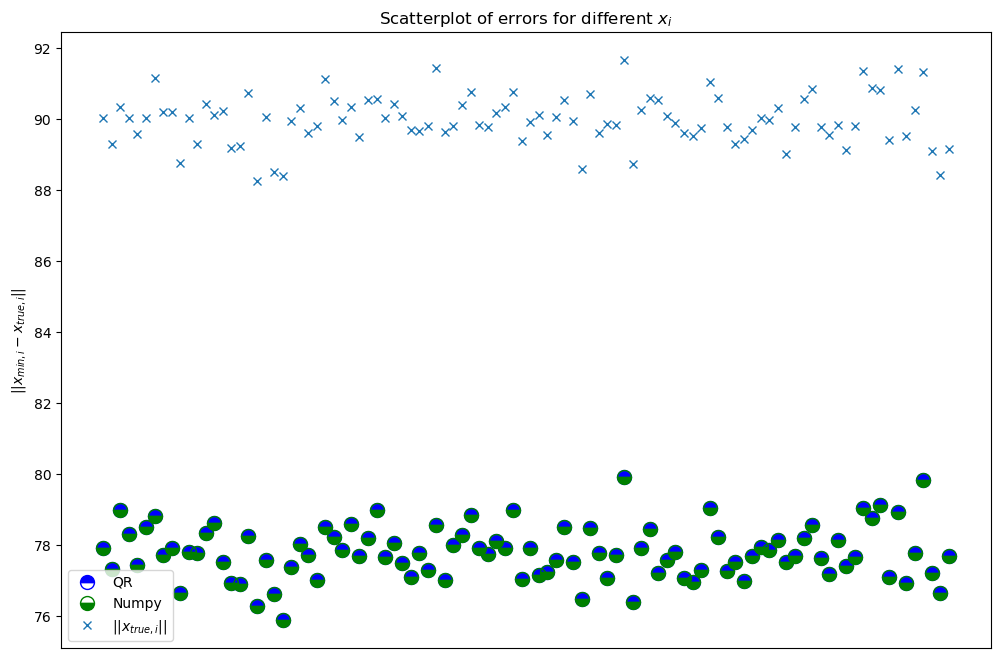

In [ ]:
#QR method
Q, R = QRDecomposition(A.T)
errors_QR=np.zeros(m)
for i in range(m):
    y = Y[:, i]
    x_min = xmin(Q, R, y)
    errors_QR[i]=np.linalg.norm(x_min-X[:,i])
#Numpy-method
errors_Numpy=np.zeros(m)
for i in range(m):
    y = Y[:, i]
    z = np.linalg.solve(AAT, y)
    x_min = np.transpose(A)@z
    errors_Numpy[i] = np.linalg.norm(x_min-X[:, i])

norm_of_x_true = np.zeros(m)
for i in range(m):
    norm_of_x_true[i] = np.linalg.norm(X[:,i])
#Plotting
plt.figure(figsize=(12, 8))
plt.title(r"Scatterplot of errors for different $x_i$")
plt.plot(errors_QR, "o", color="b", fillstyle ="top", label = "QR", markersize=10)
plt.plot(errors_Numpy, "o", color="g", fillstyle="bottom", label = "Numpy", markersize=10)
plt.plot(norm_of_x_true, "x", label = r"$||x_{true, i}||$")
plt.ylabel(r"||$x_{min, i}-x_{true, i}$||")
plt.xticks([])
plt.legend()
plt.show()

From the scatterplot above, it is clear that there is not a significant difference in numerical accuracy between the two methods, . Compared to choosing our $\textbf{x}_{min}=\textbf{0}$, we see that the error is reduced by approximately $10$ on average. This is not a great improvement, seeing as the norm of $\textbf{x}_{true}$ is around $90$, and I would say that it is hard to recover a solution in a meaningful way. 

# Task 2

In this task I will look into properties and solutions of the *Tikhonov regularisation*, which is the problem

$$
\textbf{x}_r=\arg \min _{\textbf{x}\in \mathbb{R}} ||A\textbf{x}-\textbf{y}||^2+\mu ||\textbf{x}||^2
$$

Where the scalar function $T(\textbf{x})$ is introduced to improve readability, and is given as

$$
T(\textbf{x})=||A\textbf{x}-\textbf{y}||^2+\mu||\textbf{x}||^2
$$



## 2.a)

$$
\nabla_xT(\textbf{x})=2A^TA\textbf{x}-2A^T\textbf{y}+2\mu\textbf{x}
$$

Now, since we know that $T(\textbf{x}_r)=0$, we can derive the following expression for $\textbf{x}_r$

$$
A^TA\textbf{x}_r-A^T\textbf{y}+\mu\textbf{x}_r=0 \\
(A^TA+\mu I)\textbf{x}_r = A^T\textbf{y} \quad \square
$$

Now I am interested in deciding whether the matrix that $\textbf{x}_r$ is left-multiplied by, that is $A^TA+\mu I$ is invertible. In order to decide this, I can instead determine if this matrix is symmetric-positive-definite, SPD, because if so it is also invertible. In order for a matrix $M$ to be SPD, it must be symmetric, and the following inequality must hold
$$
\textbf{x}^TM\textbf{x}>0 \quad ∀  \textbf{x} \neq \textbf{0}
$$
I first determine if the matrix is symmetric

$$
(A^TA+\mu I)^T=(A^TA)^T+(\mu I)^T=A^TA+\mu I
$$
So the matrix is symmetric. Checking the inequality 

$$
\textbf{x}^T(A^TA+\mu I)\textbf{x}= \textbf{x}^TA^TA\textbf{x}+\textbf{x}^T\mu\textbf{x} \\  
(A\textbf{x})^TA\textbf{x}+\mu\textbf{x}^T\textbf{x}=||A\textbf{x}||^2+\mu||\textbf{x}||^2 > 0 \quad \forall \textbf{x}\neq\textbf{0}
$$
Where the last inequality must hold, since both $\mu \neq 0$ and $||\textbf{x}||\neq 0$, since $\textbf{x}\neq \textbf{0}$. Therefore I have now shown that $(A^TA+\mu I)$ is SPD, and thus invertible.

## 2.b)
Using the singular value decomposition, SVD, we know that $A$ can be rewritten as $A=U\Sigma V^T$. Since we know that $U$ and $V$ are orthogonal, we have that
$$
A^TA=V\Sigma^T\Sigma V^T=VSV^T \quad S\equiv\Sigma^T\Sigma
$$
Now we can use the expression we previously derived, involving $\textbf{x}_r$, to get that
$$
(VSV^T+\mu I)\textbf{x}_r=V\Sigma ^TU^T\textbf{y}
$$
Now, since $V$ is orthogonal, we can rewrite the left-hand side to
$$
(VSV^T + V\mu IV^T)\textbf{x}_r=V\Sigma^TU^T\textbf{y}
$$
And now using the hint that for two diagonal matrices $D_1$ and $D_2$, 
$$VD_1V^T+VD_2V^T=V(D_1+D_2)V^T$$
We get that
$$
VMV^T\textbf{x}_r=V\Sigma^TU^T\textbf{y} \quad M≡S+\mu I
$$
Now solving for $\textbf{x}_r$ we get that
$$
MV^T\textbf{x}_r=V^{-1}V\Sigma^TU^T\textbf{y} \\  
\textbf{x}_r=VDU^T\textbf{y} \quad \square
$$
Where $D$ is given as
$$
D\equiv M^{-1}\Sigma^T=(S+\mu I)^{-1}\Sigma^T=(\Sigma ^T \Sigma +\mu I)^{-1}\Sigma^T\ $$
This will be a diagonal matrix, as it is the product of two diagonal matrices. Since we know that the elements of $\Sigma$ are either a singular value, that is, a $\sigma \in \left\{ \sigma_i \right \}_{i=1}^r$, or a zero. However, if we assume that $A$ is of full rank, that is that the rank is equal to $m$, $r=m$, and there will be no zeroes. This means that the elements on the diagonal of $D$ will then have the following value
$$
d_{ii}=\frac{\sigma _i}{\sigma_i^2+\mu} \quad  i≤m \\
$$
and the matrix $D$ will have dimension $n\times m$.

## 2.c)
Having this new expression for $\textbf{x}_{min}$ I now implement a function in Python to find this vector.

In [ ]:
def Tikhonov_solve(U, S, Vt, mu, y):
    """
    Function that returns the solution to the "Tikhonov regularization"-problem,
    based on the SVD-decomposition, A=U Sigma Vt, of the matrix A
    Input:
        U - (m, m)-matrix
        S - m-dimensional vector, containing the singular values of A, in descending 
        order
        Vt - (m, n)-matrix
        mu - The weight, larger than zero
        y - The right-hand-side of the equation, m-dimensional
        With m = 2048, n = 8096
    Output:
        x_r - The solution to the "Tikhonov regularization"-problem, m-dimensional
    """
    D=np.diagflat(S/(S**2+mu)) #Diagonal matrix, determined by the singular values
    #of A and the weight mu
    return Vt.T@D@U.T@y

## 2.d)
Now I again want to compare my method to using something from the Numpy library. Here I first initialize things that are needed for both experiments. An example for this is an array of weights for the QR method, with $100$ $\mu$, $\mu \in [10^{-6}, 10^6]$. Afterwards I time the precalculation of SVD and other matrices that are needed, and then I time the actual solving for each method.

In [ ]:
x_true = X[:,0]
y = Y[:,0]

musTikhonov = np.logspace(6,-6,num = 100)
n = len(musTikhonov)
x_mus = np.zeros((n,  x_true.shape[0]))
errorsTikhonovAndSVD = np.zeros((n))

numberOfMus = 10
musLinalg = np.logspace(6,-6,num = numberOfMus)
errorsLinalg = np.zeros(numberOfMus)

In [ ]:
%%timeit -r 3
global U, S, Vt
U, S, Vt = np.linalg.svd(A, compute_uv=True, full_matrices = False)


19.1 s ± 67.9 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [ ]:
%%timeit -r 3
global ATA
ATA = A.T@A
global ATy
ATy = A.T@y

1.41 s ± 79.5 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


Here we see that the precalculations for the SVD method is more costly time-wise, compared to the Numpy method. Now I measure and compare the runtimes for the actual solving-part of the numerical work in the two chunks of code below. 

In [ ]:
%%timeit -r 3
for i in range(n):
    x_mu = Tikhonov_solve(U, S, Vt, musTikhonov[i], y)
    x_mus[i] = x_mu
    errorsTikhonovAndSVD[i]=np.linalg.norm(x_true - x_mu, 2)

1min 29s ± 813 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [ ]:
%%timeit -r 3
for i in range(numberOfMus):
    muI = np.eye(np.shape(ATA)[0])*musLinalg[i]
    x_mu = np.linalg.solve(ATA+muI, ATy)
    errorsLinalg[i]= np.linalg.norm(x_true-x_mu, 2)

30.9 s ± 79.1 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


Here I have gotten results that are to some degree similar to the situation I observed for the minimal norm-problem. By this I mean that the precalculations are also here more time-costly for my "homemade" numerical solution, but that it would perform better in terms of runtime for larger-sized problems. Just to make it clear, the Tikhonov-method here uses approximately 1 and a half minute for solving my problem for a 100 different $\mu$ while the Numpy method uses approximately 30 seconds for only 5 weights. Therefore, the SVD-method is quite fast in comparison to the Numpy method. 

Having discovered this difference in runtime, I now focus on the error in each method. Here I am particularly interested in differences between the methods, will for instance the Numpy method outperform the other method in numerical accuracy, although it was defeated in the runtime-duel? Having used %%timeit earlier, I now also have to recalculate some of the things I calculated during the measurements, so the first chunk of code is really just a way of gathering together the data that previously got lost thanks to %%timeit, and then there is a chunk of code for plotting the errors.

In [ ]:
for i in range(n):
    x_mu = Tikhonov_solve(U, S, Vt, musTikhonov[i], y)
    x_mus[i] = x_mu
    errorsTikhonovAndSVD[i]=np.linalg.norm(x_true - x_mu, 2)

for i in range(numberOfMus):
    muI = np.eye(np.shape(ATA)[0])*musLinalg[i]
    x_mu = np.linalg.solve(ATA+muI, ATy)
    errorsLinalg[i]= np.linalg.norm(x_true-x_mu, 2)

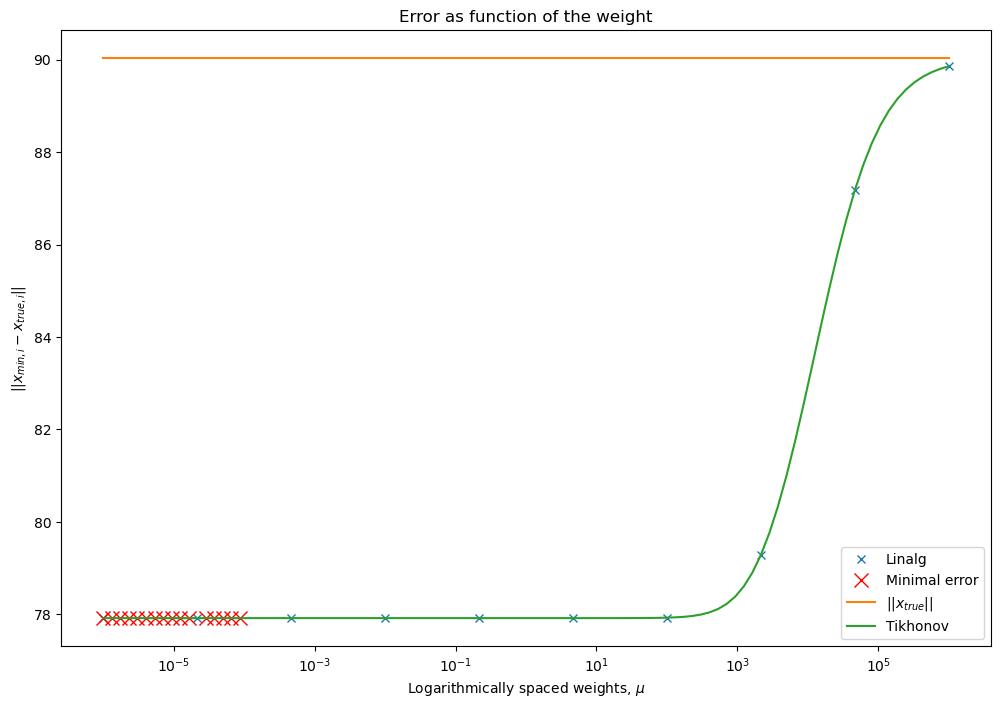

In [ ]:
result = np.where(errorsTikhonovAndSVD == np.amin(errorsTikhonovAndSVD))
plt.figure(figsize=(12, 8))
plt.title("Error as function of the weight")
plt.plot(musLinalg, errorsLinalg, "x", label = "Linalg")
plt.plot(musTikhonov[result], errorsTikhonovAndSVD[result], "x", color="r", label = "Minimal error", markersize=10)
plt.plot(musTikhonov, [np.linalg.norm(X[:,0])]*len(musTikhonov), label = r"$||x_{true}||$")
plt.plot(musTikhonov, errorsTikhonovAndSVD, label = "Tikhonov")
plt.xscale("log")
plt.xlabel(r"Logarithmically spaced weights, $\mu$")
plt.ylabel(r"$||x_r - x_{true}||$")
plt.ylabel(r"||$x_{min, i}-x_{true, i}$||")
plt.legend()
plt.show()

From the plot above, it seems that the error for the two methods are fairly similar, analogous to my observations for the "minimal norm"-problem. The plot also indicates that for $\mu > 10^3$, the accuracy of both methods quickly worsens. For our largest weight, the norm $\|\textbf{x}_r-\textbf{x}_{true}\|$ is not far from the norm $\|\textbf{x}_{true}\|$, meaning that our method does not offer a significant improvement compared to simply choosing or guessing $\textbf{x}_r=\textbf{0}$.From the plot it is also visible that choosing a rather small weight also gives the best results. My results indicate that there are several $\mu$ which lead to a minimal error, and this seems a bit strange. At the same time however, it looks like the error is somewhat constant for small $\mu$, resulting in the almost-horizontal line seen in the lower left corner in the plot. Later in this project I attempt to examine, and illustrate, further how the choice of weight affects our result, where I have made a GIF that visualizes how the choice of $\mu$ alters the appearance of the separated 0- and 1-images. 

# Task 3

I now direct my focus at the "single channel source separation"-problem. Here the optimization-problem I am looking to solve can be expressed as

$$
\arg \min_\textbf{x} \frac{1}{2}\textbf{u}^TB_0\textbf{u} + \frac{1}{2}\textbf{v}^TB_1\textbf{v}
$$
Where the definitions are as follow
$$
\textbf{x}=\begin{bmatrix}
\textbf{u} \\
\textbf{v}
\end{bmatrix} \quad \textbf{u}, \textbf{v}\in \mathbb{R}^n \\
B_i = I-W_iW_i^T \quad A= \begin{bmatrix}
I && I
\end{bmatrix}
$$
Where $\textbf{u}$ and $\textbf{v}$ are vectors that represent the separated 0- and 1-image, while $W_0$ and $W_1$ contain column vectors which will be used as bases for the 0- and 1-images. Here I will apply knowledge that I have gained from work with Tikhonov regularization and the minimal norm problem, in this order, to make an attempt to separate the images from the MNIST dataset.

### 3.a)

First of all I want to show that B is a projection matrix, which would then mean that $B^2=B$. First I examine $B^2$:

$$
B^2=(I-WW^T)(I-WW^T)=I^2-2WW^T+WW^TWW^T
$$
Now I must examine the last term, and see if I can simplify this. Since $W$ is a matrix with pairwise orthogonal columns, I know that I can rewrite $W$ in the following form, with the entries being orthogonal column vectors:

$$
W = 
\begin{bmatrix}
\textbf{w}_1 && ... && \textbf{w}_n 
\end{bmatrix}
$$
Which would again mean that 
$$
W^T=
\begin{bmatrix}
\textbf{w}_1^T \\
. \\
. \\
. \\
\textbf{w}_n^T
\end{bmatrix}
$$
Such that we can write the term $WW^T$ as
$$
W^TW=
\begin{bmatrix}
\textbf{w}_1^T \\
. \\
. \\
. \\
\textbf{w}_n^T
\end{bmatrix}
\begin{bmatrix}
\textbf{w}_1 && ... && \textbf{w}_n 
\end{bmatrix}
$$
Which means that every entry in this matrix can be written as
$$
(W^TW)_{ij}=\langle \textbf{w}_i, \textbf{w}_j\rangle
$$
Now I can utilize the fact that the columns are orthogonal, meaning that the entries can be described as
$$
(W^TW)_{ij}  =\begin{cases}
0, && j \neq i\\
\|\textbf{w}_{i}\|, && j=i
\end{cases}
$$
So, we now see that if we have normalized columns, which would mean that $\|\textbf{w}_i\|=1$, we get that 
$$
W^TW=I
$$
Which together gives that
$$
B^2= I^2-2WW^T+WIW^T=I-wW^T=B
$$
So $B$ is a projection matrix $\square$.

In order to determine if $B$ is symmetric positive-definite, I can consider its eigenvalues, and use the fact that it's a projection matrix. First of all, for an eigenvector $\textbf{v}$ of $B$, we have that

$$
B\textbf{v} = \lambda \textbf{v}  \\
$$
And now if I multiply by B once more I get that
$$
B^2\textbf{v}=\lambda B\textbf{v} = \lambda^2\textbf{x} \\
$$
And since $B$ is a projection matrix, the following must then hold
$$
B\textbf{v}=\lambda^2\textbf{v}
$$
Subtracting the third equation from the first yields
$$
(\lambda-\lambda^2)\textbf{v}=0
$$
Which has the solutions $\lambda=0$ and $\lambda=1$, meaning that $B$ only has two, and those are positive(!), eigenvalues. Now, I know that a symmetric matrix is SPD if and only if its eigenvalues are all positive. That this is true can for instance be seen from the spectral theorem which is known from courses in linear algebra. The theorem states that a square, normal, matrix $A$ may be factorised as follows
$$
A=Q^T\Lambda Q
$$
Where Q is an orthogonal matrix, and $\Lambda$ is a diagonal matrix with $A$'s eigenvalues as elements on the diagonal. So now I investigate if $A$ is SPD, using this factorization
$$
\textbf{x}^TA\textbf{x}=\textbf{x}^TQ^TΛQ\textbf{x}=\textbf{y}^T\Lambda\textbf{y}=\sum_{i=1}^n\lambda_iy_i^2
$$
Now, we see that, since $y_i^2>0 \quad \forall i$, this sum is positive if the eigenvalues of A are positive, and thus a symmetric matrix is SPD if its eigenvalues are positive.

So that if I can show that B is symmetric, and thus normal, which means that it can be factorized with the spectral theorem, it must be SPD, since its eigenvalues are also positive. In order to do this I consider $B^T$, and since transposing is linear, we get
$$
B^T=(I-WW^T)^T=I^T-(WW^T)^T=I-(W^T)^TW^T=I-W^TW=B
$$

Meaning that B must be SPD $\square$.

### 3.c) 
Having found out this about our $B$, I can now attack the problem with an approach similar to what I have previously done with Tikhonov regularization. 
Our problem is now in the form 
$$
\arg \min _{x} \|A\textbf{x}-\textbf{y}\|+\mu\|B\textbf{x}\|
$$
So, in order to find the $\textbf{x}$ we are looking for, we must again look for the $\textbf{x}_r$, such that 
$$
\nabla_{\textbf{x}}T(\textbf{x}_r)=0
$$
Where the scalar function $T(x)$ is the function we're interested in finding the $\arg \min$ of, and its gradient is given by
$$
\nabla_{\textbf{x}}T(\textbf{x})=2A^TA\textbf{x}-2A^T\textbf{y}+2\mu B^TB\textbf{x}
$$
Now solving for $\textbf{x}$, we get that, similar to the the equation we had earlier, the following must hold
$$
(A^TA+\mu B^TB)\textbf{x}_r=A^T\textbf{y}
$$
From our problem we also know that 
$$
A=
\begin{bmatrix}
I && I
\end{bmatrix}
\quad
\textbf{x}=
\begin{bmatrix}
\textbf{u} \\
\textbf{v}
\end{bmatrix}
$$
Which simplifies the above equality to 
$$
(\begin{bmatrix}
I && I
\end{bmatrix}
\begin{bmatrix}
I \\
I
\end{bmatrix} + \mu B^TB)
\begin{bmatrix}
\textbf{u} \\
\textbf{v}
\end{bmatrix}=
\begin{bmatrix}
I\\
I
\end{bmatrix}\textbf{y}
$$
Now we know another form for the matrix $B$, given as follows
$$
B = \begin{bmatrix}
B_0 && 0 \\
0 && B_1 \end{bmatrix}
\quad B_i=(I-W_iW_i^T)
$$
This is useful for simplifying the expression we're working with, since we know that $B$ itself is symmetric, whilst its diagonal entries, are for themselves SPD, such that the following must hold
$$
(\begin{bmatrix}
I && I \\
I && I
\end{bmatrix}
+ \mu \begin{bmatrix}
B_0 && 0  \\
0 && B_1 \end{bmatrix})
\begin{bmatrix}
\textbf{u} \\
\textbf{v}
\end{bmatrix}=
\begin{bmatrix}
\textbf{y}\\
\textbf{y}
\end{bmatrix}
$$
Which lastly gives 
$$
\begin{bmatrix}
I + \mu (I-W_0W_0^T) && I \\
I && I+ \mu (I-W_1W_1^T)
\end{bmatrix}
\begin{bmatrix}
\textbf{u} \\
\textbf{v}
\end{bmatrix}
=\begin{bmatrix}
\textbf{y} \\
\textbf{y}
\end{bmatrix}
$$

Now we can solve this system of equations for our $\textbf{u}$ and $\textbf{v}$, and we want it on the form $C_0\textbf{u}=\textbf{d}_0$ and $C_1\textbf{v}=\textbf{d}_1$, we'll just have to do a bit of tedious work first. From our equality above we get the following two equalities, again applying the definition of $B_i$
$$
(I) \quad \textbf{u}+ \mu B_0\textbf{u}+\textbf{v}=\textbf{y}\\ 
(II) \quad \textbf{u}+ \mu B_1\textbf{v}+\textbf{v}=\textbf{y}
$$
Isolating $\textbf{u}$ then gives
$$
\textbf{u}=\textbf{y}-(I+\mu B_1)\textbf{v}
$$
Substituting back into $(I)$ then yields
$$
\textbf{y}-(I+\mu B_1)\textbf{v} + 
\mu B_0(\textbf{y}-(I+\mu B_1)\textbf{v})  + \textbf{v}=\textbf{y} \\
\textbf{v} + \mu B_1\textbf{v} + \mu B_0\textbf{v}+\mu^2 B_0B_1\textbf{v} -\textbf{v} = \mu B_0 \textbf{y} \\
(B_0+B_1 + \mu B_0B_1)\textbf{v}=B_0 \textbf{y}
$$
This means that we can write this equation in a nicer form as 
$$
C_1\textbf{v}=\textbf{d}_1 \\
C_1 \equiv B_0+B_1 + \mu B_0B_1 \quad \textbf{d}_1 \equiv B_0\textbf{y}
$$
And because of the symmetry of our set of equations we can also write
$$
C_0\textbf{u}=\textbf{d}_0 \\
C_0 \equiv B_0+B_1 + \mu B_1B_0 \quad \textbf{d}_0 \equiv B_1\textbf{y}
$$

Just to make it clear, I have here chosen to solve two sets of equations, one for each separated image. This might take more time than for instance solving the set of equations for one image, and then solving for the other by simply multiplying and subtracting or adding matrices, for instance by the equality 

$$
\textbf{u}=\textbf{y}-(I+\mu B_1)\textbf{v}
$$

If I had first solved for $\textbf{v}$. A possible advantage of this might be that if something had gone wrong in the calculation of one image, this error might not necessarily propagate into the error for the other image. Regarding the time needed for this calculation this is examined further at the end of this project. 

Below I implement a function that solves these systems of equations in order to return our separated images. This function uses Numpy-functions in order to fullfil its purpose, and this choice was mainly made due to the fact that I have previously seen that it is often faster, and at least as accurate as, my "homemade" methods, while at the same time being far easier to implement. I have made the same choice for my work with the minimal norm-method, for the same reasons. 

In [ ]:
def calculate_separated_channels_tikhonov(y, W0, W1, mu):
    """
    Function that returns separated images of 0s and 1s, from the combined picture
    y, based on the equations I derived earlier, and the bases W0 and W1, plus the 
    weight mu.
    Input: 
        y - 728-dimensional vector, representing the combined image
        W0 - (728x16)-matrix, containing the 
        W1 - (728x16)-matrix, containing
        mu - The weight
    Output:
        u -The separated 0 image, 728-dimensional vector
        v -The separated 1 image, 728-dimensional vector
    """
    I = np.eye(np.shape(y)[0])
    B0=I-W0@W0.T
    B1=I-W1@W1.T
    C0 = B0+B1+mu*B0@B1
    C1 = B0+B1+mu*B1@B0
    u = np.linalg.solve(C0, B1@y)
    v = np.linalg.solve(C1, B0@y)
    return u, v


Having implemented this function I now load in my data, and plot some of the images from the dataset, mainly with handed out code.

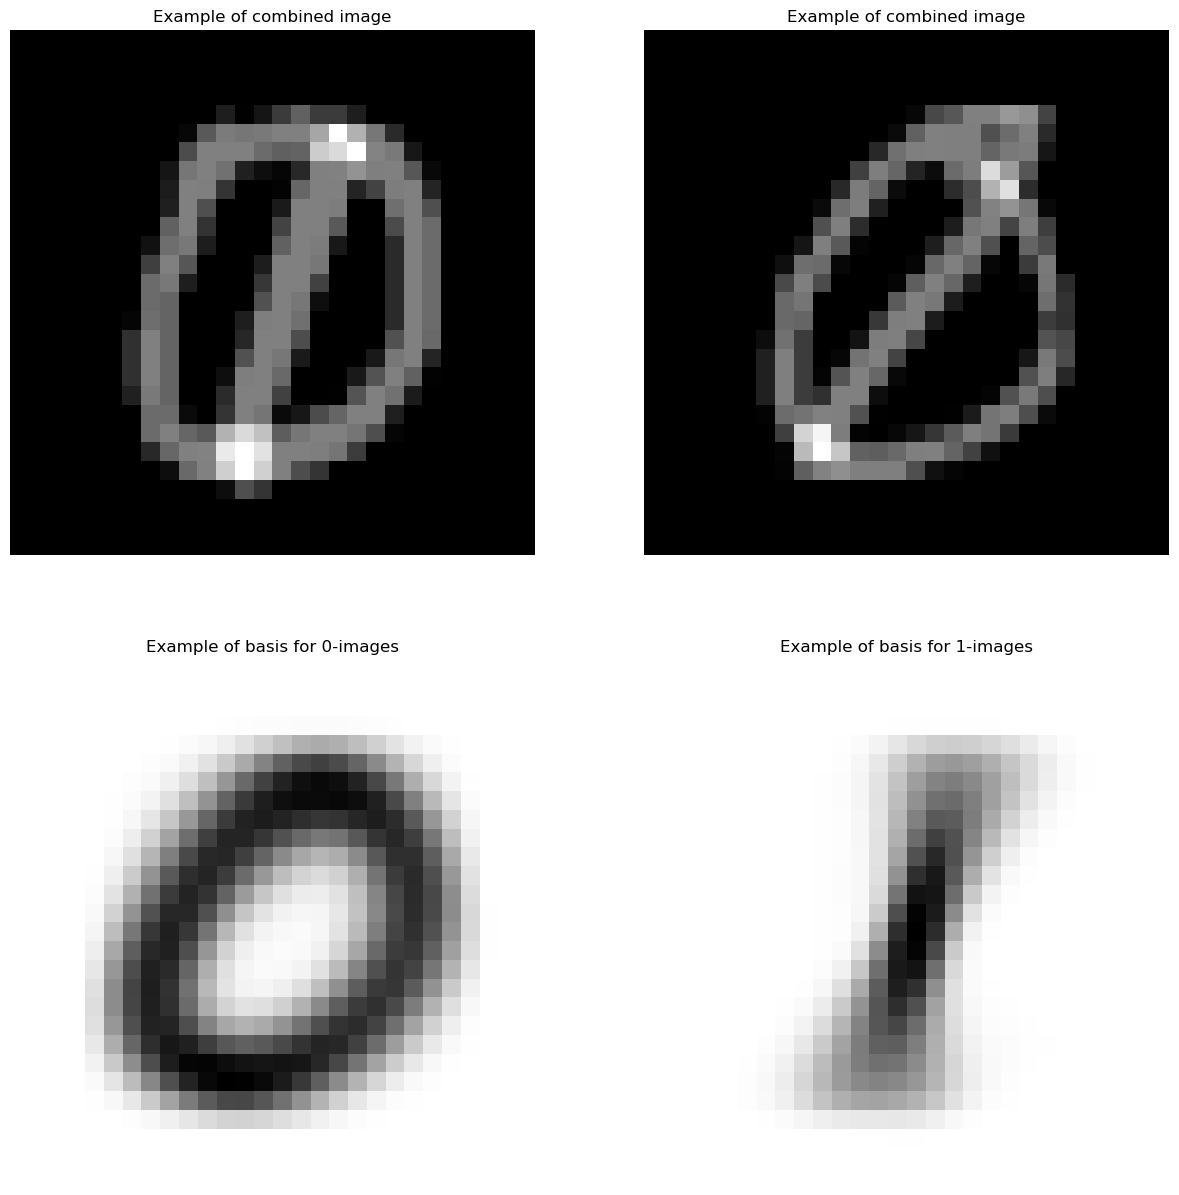

In [ ]:
#Loading the images from the data set - handed out code
Mixes = np.load('Data/mixed.npy')

W0 = np.load('Data/W0.npy')
W1 = np.load('Data/W1.npy')

#Displaying the images

figure, axis = plt.subplots(2, 2)
figure.set_figheight(15)
figure.set_figwidth(15)
axis[0, 0].imshow(Mixes[:,1].reshape((28,28)), cmap = 'gray')
axis[0, 0].axis("off")
axis[0, 0].set_title("Example of combined image")

axis[0, 1].imshow(Mixes[:,50].reshape((28,28)), cmap = 'gray')
axis[0, 1].axis("off")
axis[0, 1].set_title("Example of combined image")

axis[1, 0].imshow(W0[:,0].reshape((28,28)), cmap = 'gray')
axis[1, 0].axis("off")
axis[1, 0].set_title("Example of basis for 0-images")

axis[1, 1].imshow(W1[:,0].reshape((28,28)), cmap = 'gray')
axis[1, 1].axis("off")
axis[1, 1].set_title("Example of basis for 1-images")

plt.show()

Having seen examples of what the data-set looks like, I now want to apply the "Tikhonov regression"-approach I have developed, and particularly study how the choice of weight affects the separated images. This is done by choosing the first image in the "Mixes"-matrix, and then doing the image separation for 100 different values of $\mu$, and the results are then presented in a GIF.

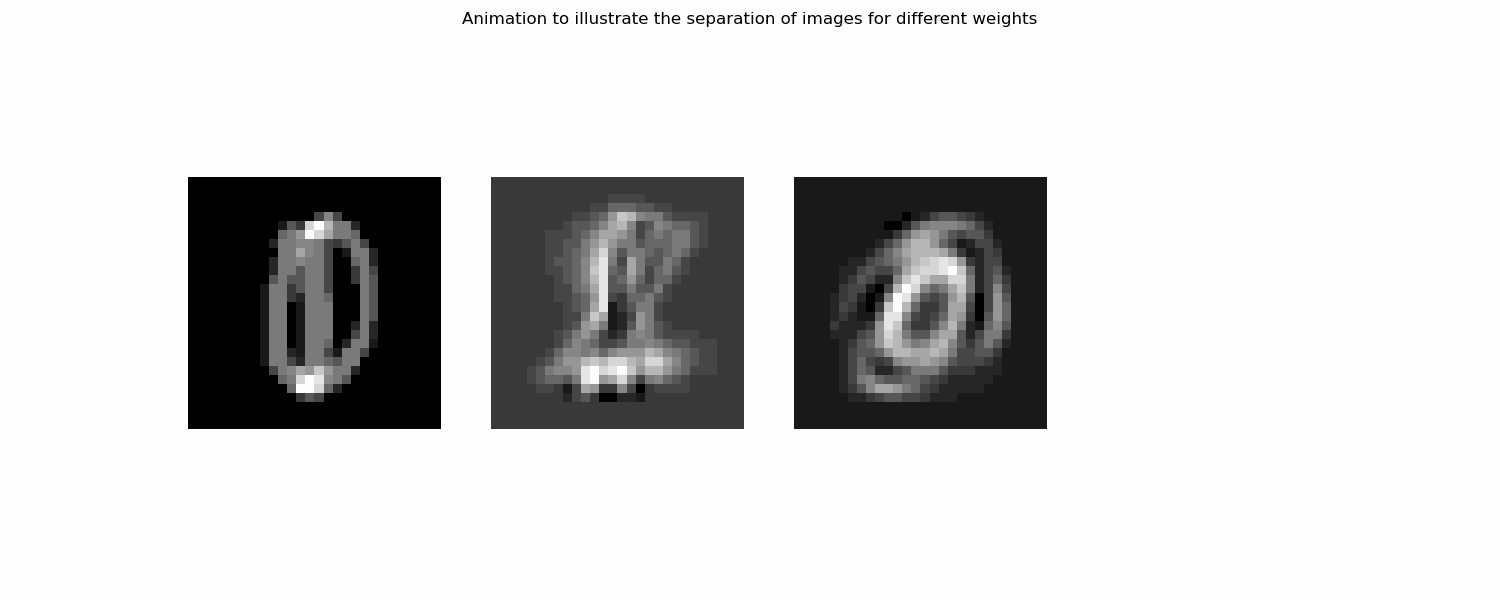

In [ ]:
#Initialization of needed variables
combinedImage=Mixes[:, 10]
NPlots=100
mus = np.logspace(6, -6, NPlots)
us = np.zeros((NPlots, len(combinedImage)))
vs = np.copy(us)
#Separation of images and storing of these images
for i in range(len(mus)):
    u, v = calculate_separated_channels_tikhonov(combinedImage, W0, W1, mus[i])
    us[i]=u
    vs[i]=v

#Making of GIF
fig, ax = plt.subplots(figsize=(15,6), ncols = 4)
fig.suptitle("Animation to illustrate the separation of images for different weights")
def animate(i):
    ax[0].imshow(combinedImage.reshape((28,28)), cmap = 'gray')
    ax[0].axis("off")
    
    ax[1].imshow(us[i].reshape((28, 28)), cmap='gray')
    ax[1].axis("off")

    ax[2].imshow(vs[i].reshape((28, 28)), cmap='gray')
    ax[2].axis("off")
    
    text_string = f"Original image to the left.\nSeparated 0-image in the middle \nSeparated 1-image to the right.\n"+rf"Using weight = {mus[i]:.3E}"
    ax[3].text(0, 0.4, text_string, size=16, bbox=dict(boxstyle="round, pad=0.5",fc=(0.95, 1, 1)))
    ax[3].axis("off")
anim = animation.FuncAnimation(fig, animate, interval=150, frames=NPlots)
anim.save('Animations/TikhonovImages.gif', writer='pillow')
#Displays animation
with open('Animations/TikhonovImages.gif','rb') as file:
    display(Image(file.read()))
plt.close()

From the GIF, we can again see an example of a trend I pointed out earlier, namely that a smaller weight $\mu$ leads to better separated images $u$ and $v$. By this I mean that these images bear stronger visual resemblance to 0s and 1s, than the images do for large $\mu$.  However, it should also be noted that this improvement is not necessarily linear, as the improvement is no longer as apparent between each image for $\mu ⪅ 10^{-1}$. Thus choosing an extremely small weight does not necessarily yield better results than choosing just a small weight. However, as the choice of $\mu$ should not affect the run-time, I see no reason not to choose an extremely small $\mu$ for better reconstructions. 


## 3.b)

In addition to our Tikhonov regularization-approach, we can also consider the "least norm"-approach in solving the problem concerning single channel source separation. In this case, we need to know the Lagrange function, which is here given as 

$$
L(\textbf{x}, \lambda)=\frac{1}{2}\textbf{x}^TB\textbf{x}+\lambda^T(A\textbf{x}-\textbf{y})
$$
As earlier, I here have to consider the gradients, which I have, similarly to previous calculations, calculated as:
$$
\nabla_\textbf{x}L=\frac{1}{2}(B^T+B)\textbf{x}+A^T\lambda \\
\nabla_\lambda L=A\textbf{x}+\textbf{y}
$$
Setting both gradients equal to zero yields the system
$$
\begin{bmatrix}
\frac{1}{2}(B^T+B) && A^T \\
A && 0
\end{bmatrix} \begin{bmatrix}
\textbf{x} \\
\lambda
\end{bmatrix} = \begin{bmatrix}
0 \\
\textbf{y}
\end{bmatrix}
$$
Using our previous definitions for $A$, $B$ and $\textbf{x}$, plus the fact that $B$ is symmetric, meaning that $B+B^T=2B$, we get the following system
$$
\begin{bmatrix}
I-W_0W_0^T && 0 && I \\
0 && I-W_1W_1^T && I \\
I && I && 0
\end{bmatrix} \begin{bmatrix}
\textbf{u} \\
\textbf{v} \\
\lambda
\end{bmatrix} = \begin{bmatrix}
0 \\ 0 \\ \textbf{y}
\end{bmatrix}
$$
Now, I wish to eliminate $\lambda$, and since appears in the first and second equation in my system, I can easily isolate $\lambda$ from each of them, and then setting the two expressions equal to each ther. Doing this, and reintroducing the matrices $B_0$ and $B_1$, gives that the following equality must hold
$$
B_0 \textbf{u}=B_1\textbf{v}
$$
Since the third equation is $\textbf{u}+\textbf{v}=\textbf{y}$, which I can use to solve the above equation for $\textbf{u}$ as
$$
B_0\textbf{u}=B_1(\textbf{y}-\textbf{u}) \\
(B_0+B_1)\textbf{u}=B_1\textbf{y}
$$
Below I implement these relations in a Python-function in order to find our separated images. 

In [ ]:
def calculate_separated_channels_least_norm(y, W0, W1):
    """
    Function that returns separated images of 0s and 1s, from the combined picture
    y, based on the equations I derived earlier for the least-norm-approach,
    and the bases W0 and W1.
    Input: 
        y - 728-dimensional vector, representing the combined image
        W0 - (728x16)-matrix, containing the 
        W1 - (728x16)-matrix, containing
    Output:
        u -The separated 0 image, 728-dimensional vector
        v -The separated 1 image, 728-dimensional vector
    """
    I = np.eye(len(y))
    B0=I-W0@W0.T
    B1=I-W1@W1.T
    u = np.linalg.solve(B0+B1, B1@y)
    v = y-u
    return u, v

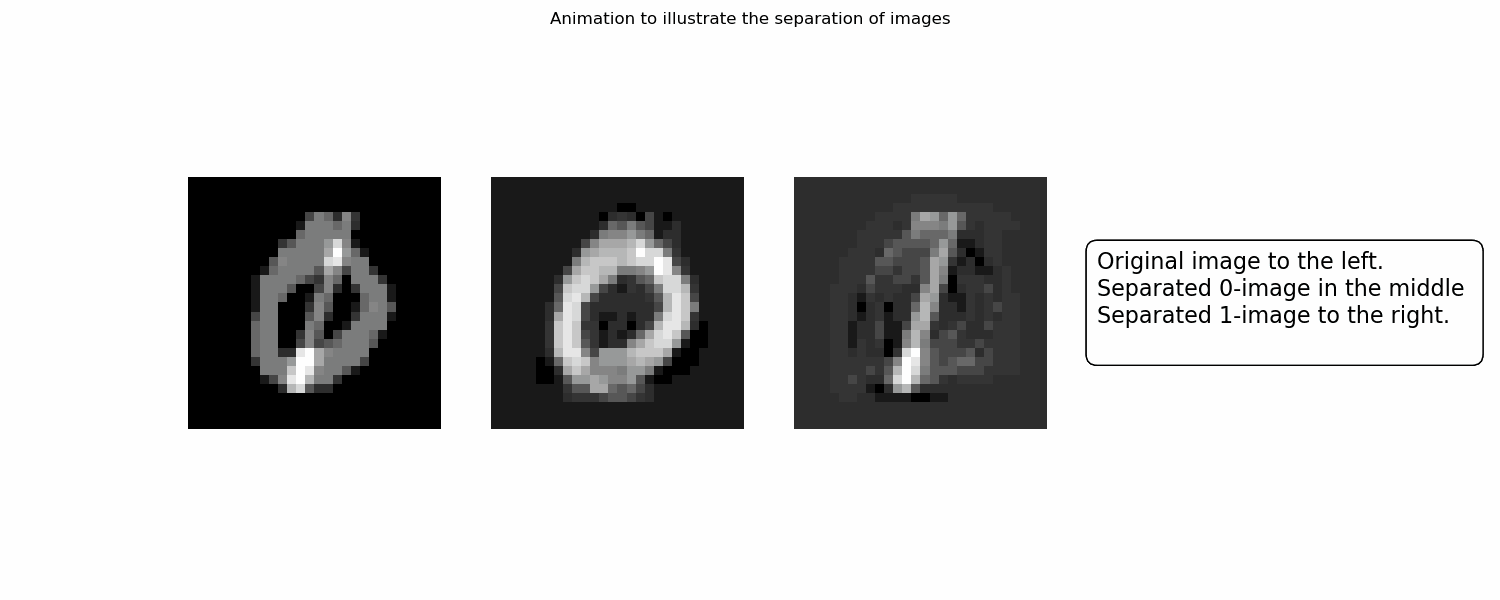

In [ ]:
NPlots=100

for i in range(NPlots):
    y = Mixes[:,i]
    u, v = calculate_separated_channels_least_norm(y, W0, W1)
    us[i]=u
    vs[i]=v

fig, ax = plt.subplots(figsize=(15,6), ncols = 4)
fig.suptitle("Animation to illustrate the separation of images")
def animate(i):
    ax[0].imshow(Mixes[:,i].reshape((28,28)), cmap = 'gray')
    ax[0].axis("off")
    
    ax[1].imshow(us[i].reshape((28, 28)), cmap='gray')
    ax[1].axis("off")

    ax[2].imshow(vs[i].reshape((28, 28)), cmap='gray')
    ax[2].axis("off")
    
    
    text_string = f"Original image to the left.\nSeparated 0-image in the middle \nSeparated 1-image to the right.\n"
    ax[3].text(0, 0.4, text_string, size=16, bbox=dict(boxstyle="round, pad=0.5",fc=(0.95, 1, 1)))
    ax[3].axis("off")
anim = animation.FuncAnimation(fig, animate, interval=1500, frames=NPlots)
anim.save('Animations/least_norm.gif', writer='pillow')
#Displays animation
with open('Animations/least_norm.gif','rb') as file:
    display(Image(file.read()))
plt.close()

From the GIF above I would say that the separated images are in general decent, with some variation, since some images are more blurry than others. However, in comparison with the separated images that resulted from the Tikhonov-approach, I would say that these separations are better than the images that resulted from choosing a too large $\mu$, whilst for small $\mu$, the separated images from the Tikhonov-approach might qualitatively surpass those from the least norm-approach. 

## 3.d)
Knowing this, I now want to examine the method's runtimes, to maybe get another pointer at how the methods perform in comparison to eachother. The test is performed by timing the separation of 100 images for each method, starting with the minimal norm-method. 

In [ ]:
%%timeit -r 3
for i in range(NPlots):
    y = Mixes[:,i]
    u, v = calculate_separated_channels_least_norm(y, W0, W1)
    us[i]=u
    vs[i]=v

1.43 s ± 84.1 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [ ]:
%%timeit -r 3
for i in range(NPlots):
    y = Mixes[:,i]
    u, v = calculate_separated_channels_tikhonov(y, W0, W1, 1)
    us[i]=u
    vs[i]=v

6.07 s ± 1.31 s per loop (mean ± std. dev. of 3 runs, 1 loop each)


From the tests above, it is clear that the minimal norm-approach is the faster method. I would also say that qualitatively the minimal norm-images are decent separations of the original images. I would say that this is also the case for the separated images that result from the Tikhonov regularization-approach, given that you choose a small enough weight. This however should be no problem, if one first takes the time to study how different weights affect the separated images. All in all I would therefore say that both approaches work for single channel source separation, with the minimal norm-approach being the fastest, while the Tikhonov-regularization-approach might seem to lead to slightly better separated images, given a good weight. 

# Conclusion

Through this project I have gained insight into why the methods I have implemented should work, and why we are allowed to do what we have done in order to solve the single channel source separation problem. Regarding these solutions I have seen that both methods yield qualitatively nice results, especially that the minimal norm-approach gives good results on average. At the same time, the Tikhonov regularization-approach demands some more familiarization with the parameter $\mu$ in order to get good results. This is something that is also nice to have experienced; sometimes you need to explore and experiment in order to get the results you want.